# Análise de mercado de veículos Honda Civic no estado da Califórnia
## Parte 4 - Gráficos da análise em SQL de tendência de preço baseada na idade e quilometragem dos veículos, e cidade do revendedor.

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from src.visualization import (
    plot_bars, plot_bars_horizontal,
    plot_line
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Panorama geral dos veículos
### 1.1 Distribuição de veículos por idade

In [2]:
df_veiculos_idade = pd.read_csv("../data/sql_exports/idade_qtd_veiculos.csv")

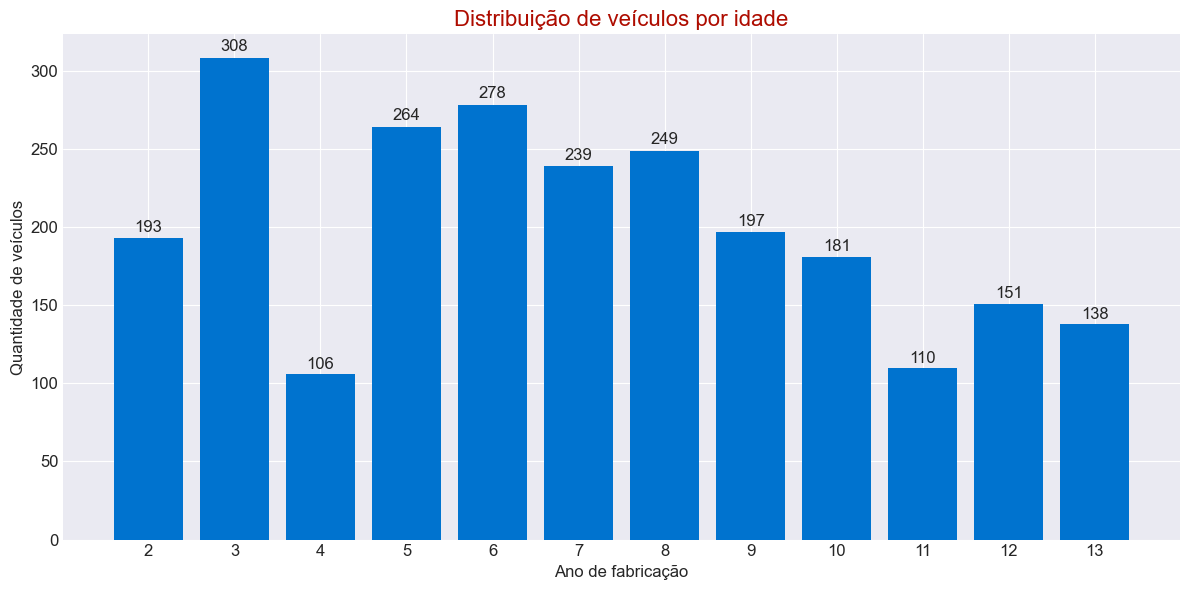

In [3]:
plot_bars(df_veiculos_idade, "idade", 'qtd_veiculos', "Ano de fabricação", 
          "Quantidade de veículos", "Distribuição de veículos por idade", (12, 6), 0)

### 1.2 Distribuição de revendedores por cidade

In [4]:
df_cidades = pd.read_csv("../data/sql_exports/dist_cidade.csv")

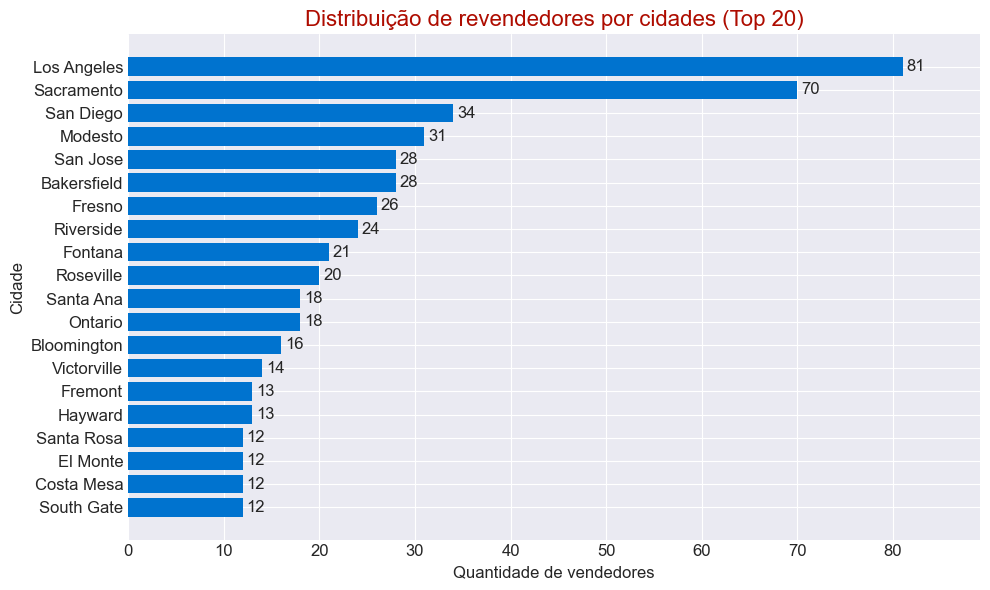

In [5]:
plot_bars_horizontal(df_cidades.nlargest(20, 'qtd_revendedores').sort_values('qtd_revendedores', ascending=True), 
                     "cidade_revendedor", "qtd_revendedores", "Cidade", "Quantidade de vendedores", 
                     "Distribuição de revendedores por cidades (Top 20)", (10,6))

## 1.3 Distribuição por quilometragem

In [6]:
df_km = pd.read_csv("../data/sql_exports/depreciacao_km.csv")

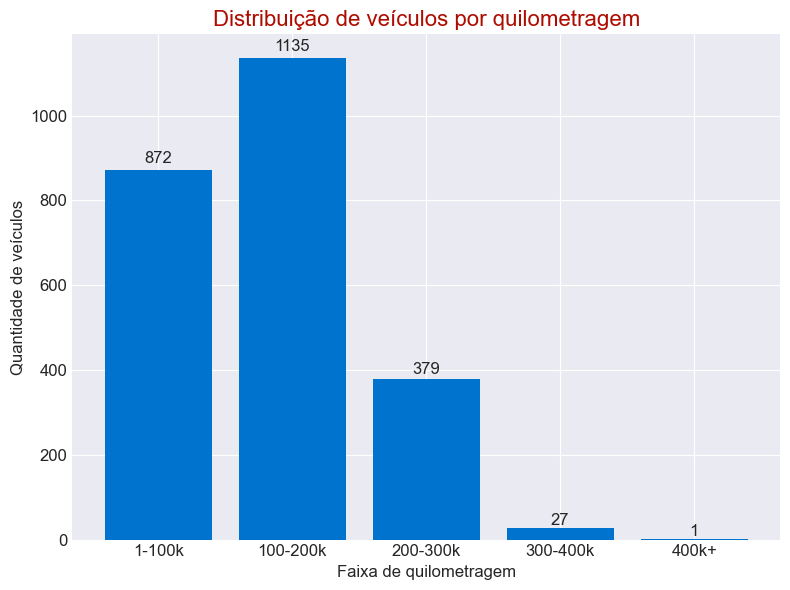

In [7]:
plot_bars(df_km, "faixa_km", 'n', "Faixa de quilometragem", 
          "Quantidade de veículos", "Distribuição de veículos por quilometragem", (8, 6), 0)

## 2. Preço e depreciação

### 2.1 Tendência de preço médio por idade do veículo

In [8]:
df_idade_preco_medio = pd.read_csv("../data/sql_exports/idade_preco_medio.csv")

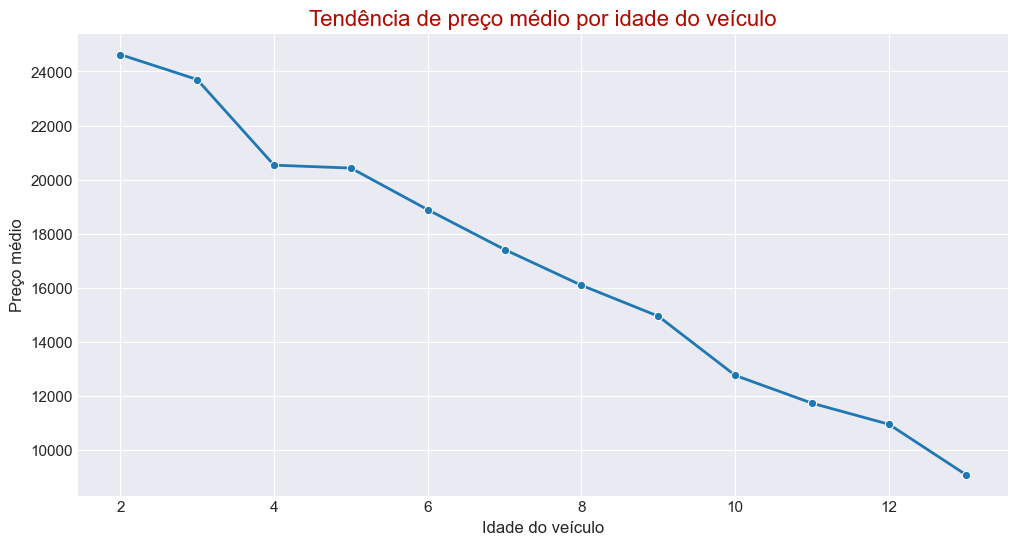

In [9]:
plot_line(df_idade_preco_medio, "idade", "preco_medio", "Tendência de preço médio por idade do veículo", 
          "Idade do veículo", "Preço médio", (12,6))

### 2.2 Depreciação por faixa de quilometragem

In [10]:
# Remove do plot a faixa km utilizada como referência
df_plot = df_km.copy()
df_plot['pct_desvalorizacao'] = pd.to_numeric(df_plot['pct_desvalorizacao'], errors='coerce')
df_plot = df_plot.dropna(subset=['pct_desvalorizacao'])

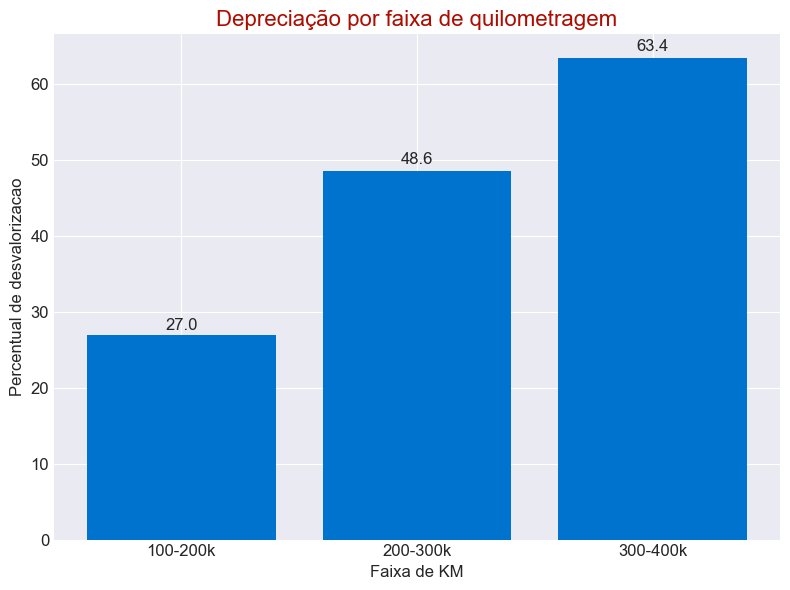

In [11]:
# Removi 400k+ do plot por ter apenas um veículo nesta faixa de preço
plot_bars(df_plot.head(3), "faixa_km", 'pct_desvalorizacao', "Faixa de KM", 
          "Percentual de desvalorizacao", "Depreciação por faixa de quilometragem", (8, 6), 0)

### 2.3 Interação entre idade e quilometragem

In [12]:
df_faixa_ano = pd.read_csv("../data/sql_exports/faixa_ano.csv")

In [13]:
pivot_table = df_faixa_ano.pivot(index='faixa_km', columns='idade', values='preco_medio')

In [14]:
def plot_heatmap(df, x_label, y_label, title, figsize):
	plt.figure(figsize=figsize)
	sns.heatmap(df, annot=True, fmt=".0f", cmap="YlOrRd", linewidths=0.5)
	plt.title(title, fontsize=16, color='#ae0c00')
	plt.xlabel(x_label, fontsize=12)
	plt.ylabel(y_label, fontsize=12)
	plt.xticks(fontsize=12)
	plt.yticks(fontsize=12)
	plt.tight_layout()
	plt.show()

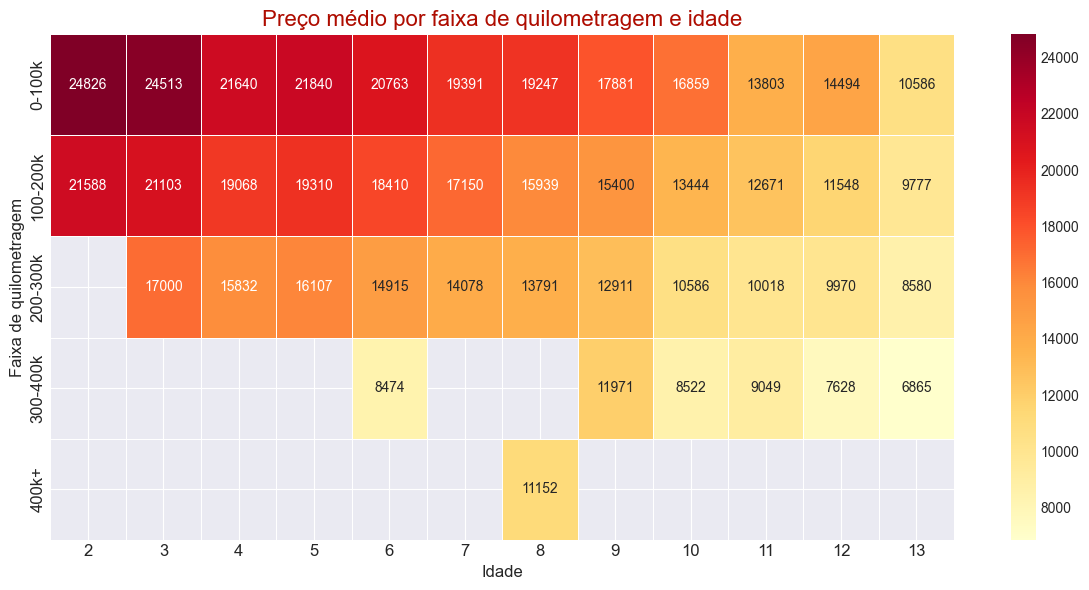

In [15]:
plot_heatmap(pivot_table, "Idade", "Faixa de quilometragem", "Preço médio por faixa de quilometragem e idade", (12, 6))

### 2.4 Veículos com preço abaixo da média seguindo o padrão visível entre idade e quilometragem

In [16]:
df_outliers_preco_km = pd.read_csv("../data/sql_exports/outliers_preco_km.csv")

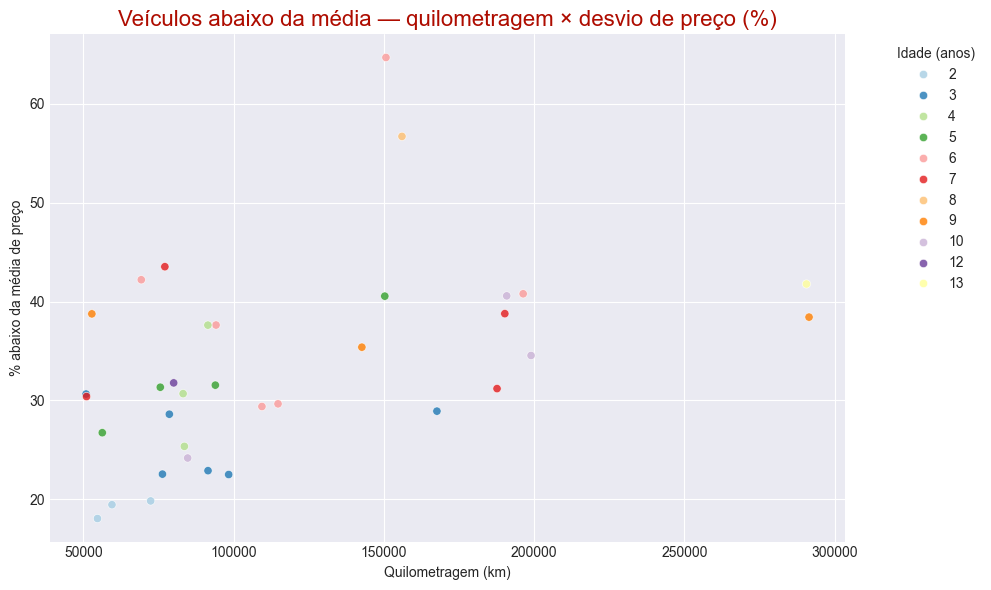

In [17]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_outliers_preco_km,
    x='quilometragem',
    y='pct_abaixo_media',
    hue='idade',
    palette='Paired',
    alpha=0.8
)
plt.title("Veículos abaixo da média — quilometragem × desvio de preço (%)", fontsize=16, color='#ae0c00')
plt.xlabel("Quilometragem (km)")
plt.ylabel("% abaixo da média de preço")
plt.legend(title="Idade (anos)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
df_data_veiculos = pd.read_csv("../data/processed/veiculos_full_data.csv")

In [19]:
df_outliers = df_outliers_preco_km.merge(
    df_data_veiculos[['chassi', 'cidade_revendedor']],
    on='chassi',
    how='left'
)

In [20]:
df_outliers[df_outliers['pct_abaixo_media'] > 50]

,chassi,idade,quilometragem,preco_usd,preco_medio,pct_abaixo_media,cidade_revendedor
0,19XFC2F64KE206831,6,150697,6500.0,18410.15,64.69,Roseville
1,2HGFC4B54HH304801,8,156023,6900.0,15939.48,56.71,Roseville


## 3. Análise de preço por cidade

### 3.1 Maiores e menores preços médios

In [21]:
df_preco_medio_cidade = pd.read_csv("../data/sql_exports/preco_medio_cidade.csv")

In [22]:
df_top = df_preco_medio_cidade.nlargest(15, 'preco_medio')
df_top = df_top.sort_values('preco_medio', ascending=True)

In [23]:
df_bottom = df_preco_medio_cidade.nsmallest(15, 'preco_medio')
df_bottom = df_bottom.sort_values('preco_medio', ascending=False)

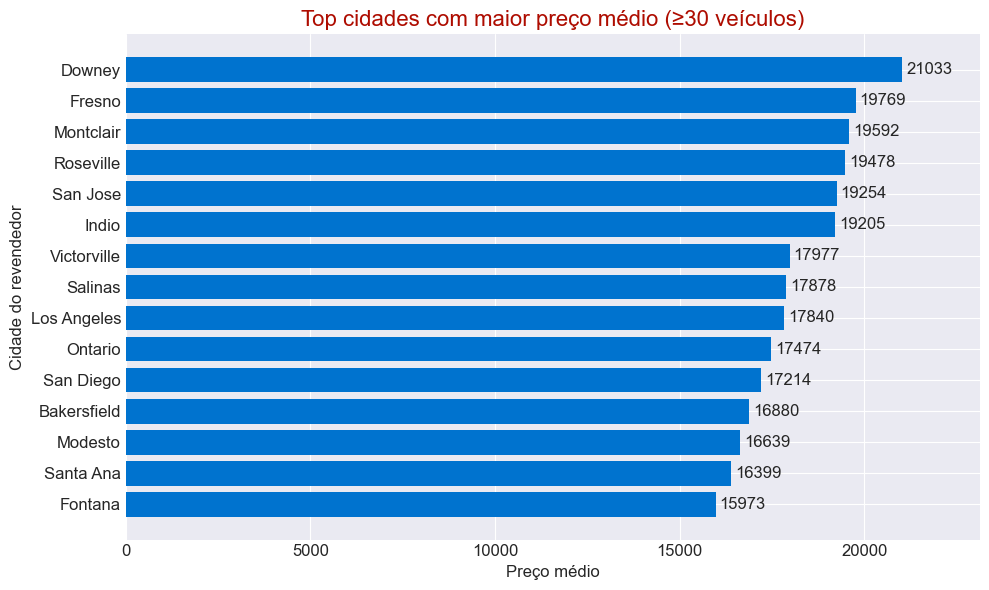

In [24]:
plot_bars_horizontal(
    df_top, 
    x='cidade_revendedor', 
    y='preco_medio', 
    x_label="Cidade do revendedor", 
    y_label="Preço médio", 
    title="Top cidades com maior preço médio (≥30 veículos)", 
    figsize=(10,6)
)

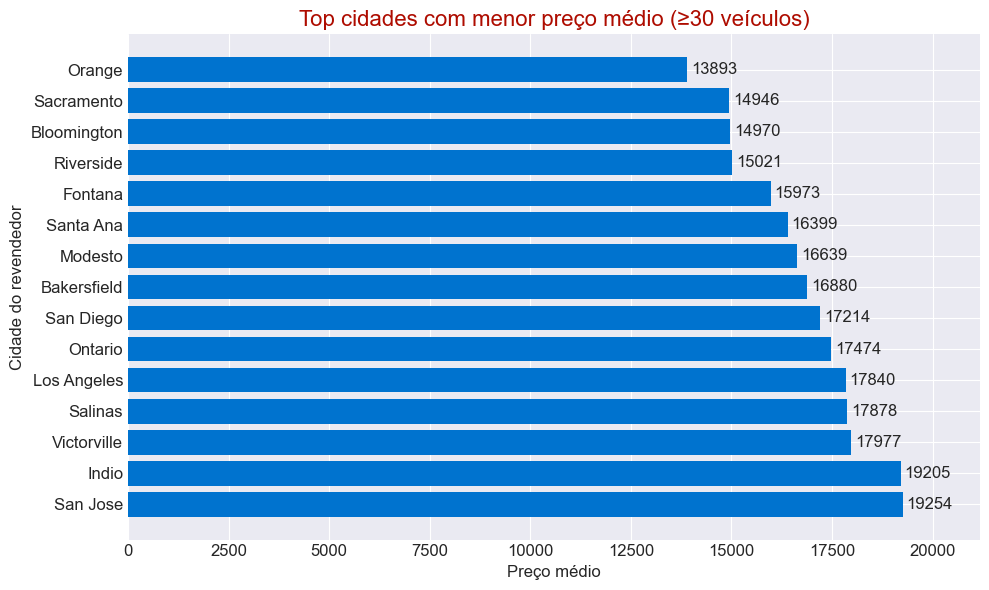

In [25]:
plot_bars_horizontal(
    df_bottom, 
    x='cidade_revendedor', 
    y='preco_medio', 
    x_label="Cidade do revendedor", 
    y_label="Preço médio", 
    title="Top cidades com menor preço médio (≥30 veículos)", 
    figsize=(10,6)
)

### 3.1 Quais cidades têm mais casos extremos de desvalorização em relação ao total de veículos vendidos?
### 3.1 Cidades com maior incidência de casos extremos de desvalorização em relação ao total de veículos vendidos

In [26]:
df_outliers_cidade = pd.read_csv("../data/sql_exports/outliers_cidade.csv")

In [27]:
df_outliers_cidade.head()

,cidade_revendedor,n_abaixo_media,total_veiculos,pct_abaixo_media
0,El Cajon,6,28,21.43
1,San Bernardino,1,13,7.69
2,Downey,2,31,6.45
3,Tracy,1,18,5.56
4,Sacramento,7,131,5.34


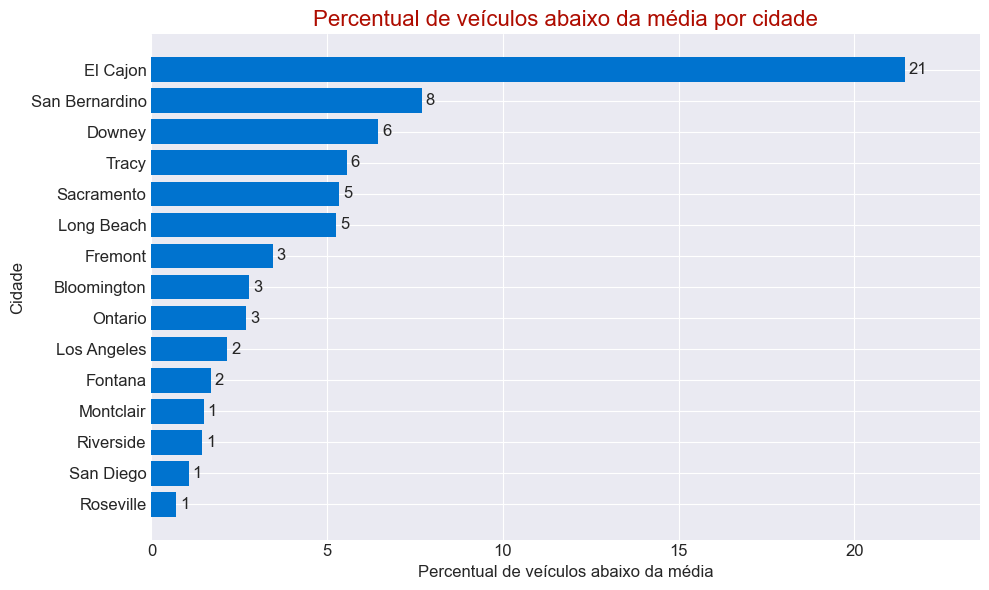

In [28]:
df_outliers_cidade_filtrado = df_outliers_cidade[df_outliers_cidade['pct_abaixo_media'] > 0]
df_outliers_cidade_filtrado = df_outliers_cidade_filtrado.sort_values('pct_abaixo_media', ascending=True)

plot_bars_horizontal(
    df_outliers_cidade_filtrado, 
    x='cidade_revendedor', 
    y='pct_abaixo_media', 
    x_label='Cidade',
    y_label='Percentual de veículos abaixo da média',
    title='Percentual de veículos abaixo da média por cidade', 
    figsize=(10,6)
)

### 3.2 Comparativo de preço médio por cidade e faixa de quilometragem

In [29]:
df_cidade_faixa_preco = pd.read_csv("../data/sql_exports/cidade_faixa_preco.csv")

In [30]:
df_cidade_faixa_preco.head()

,cidade_revendedor,faixa_km,preco_medio,total_veiculos
0,Bakersfield,0-100k,23390.75,12
1,Bakersfield,100-200k,16881.18,34
2,Bakersfield,200-300k,11667.47,15
3,Bloomington,100-200k,17152.05,19
4,Bloomington,200-300k,12068.00,15


In [31]:
df_pivot = df_cidade_faixa_preco.pivot(index='cidade_revendedor', columns='faixa_km', values='preco_medio')
df_pivot['media_geral'] = df_pivot.mean(axis=1)
df_pivot = df_pivot.sort_values('media_geral', ascending=False).drop(columns='media_geral')

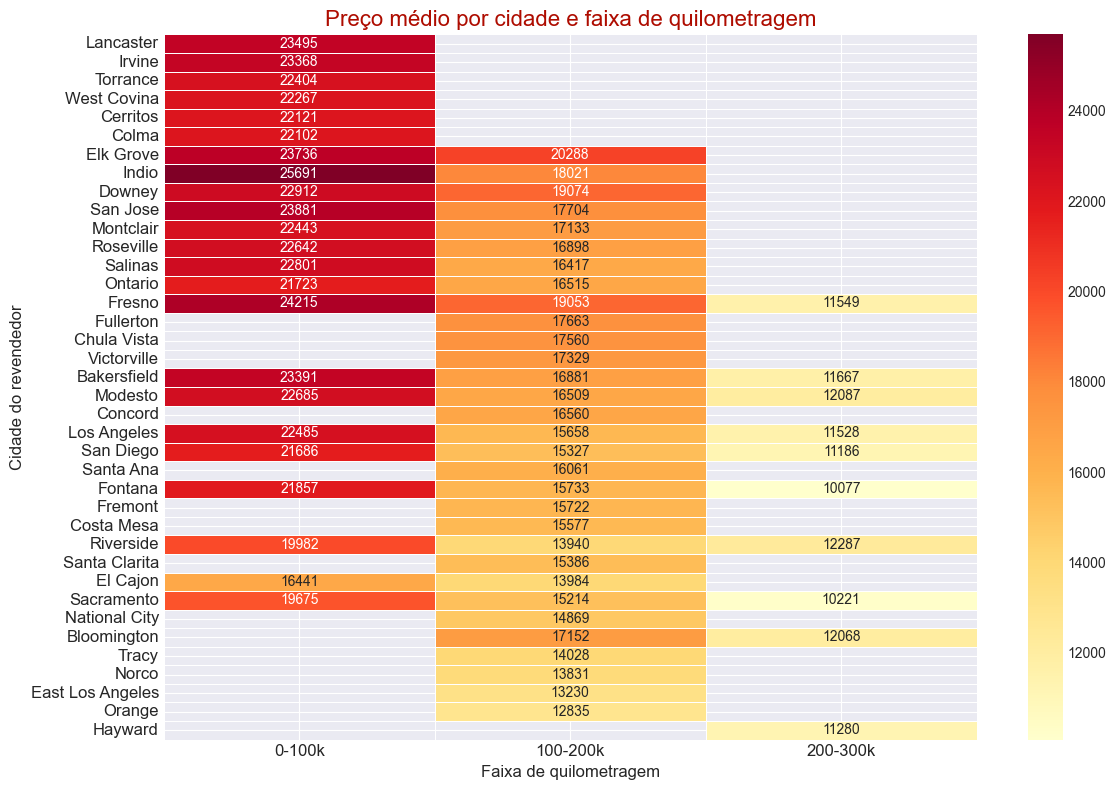

In [32]:
plot_heatmap(df_pivot, "Faixa de quilometragem", "Cidade do revendedor", "Preço médio por cidade e faixa de quilometragem", (12, 8))

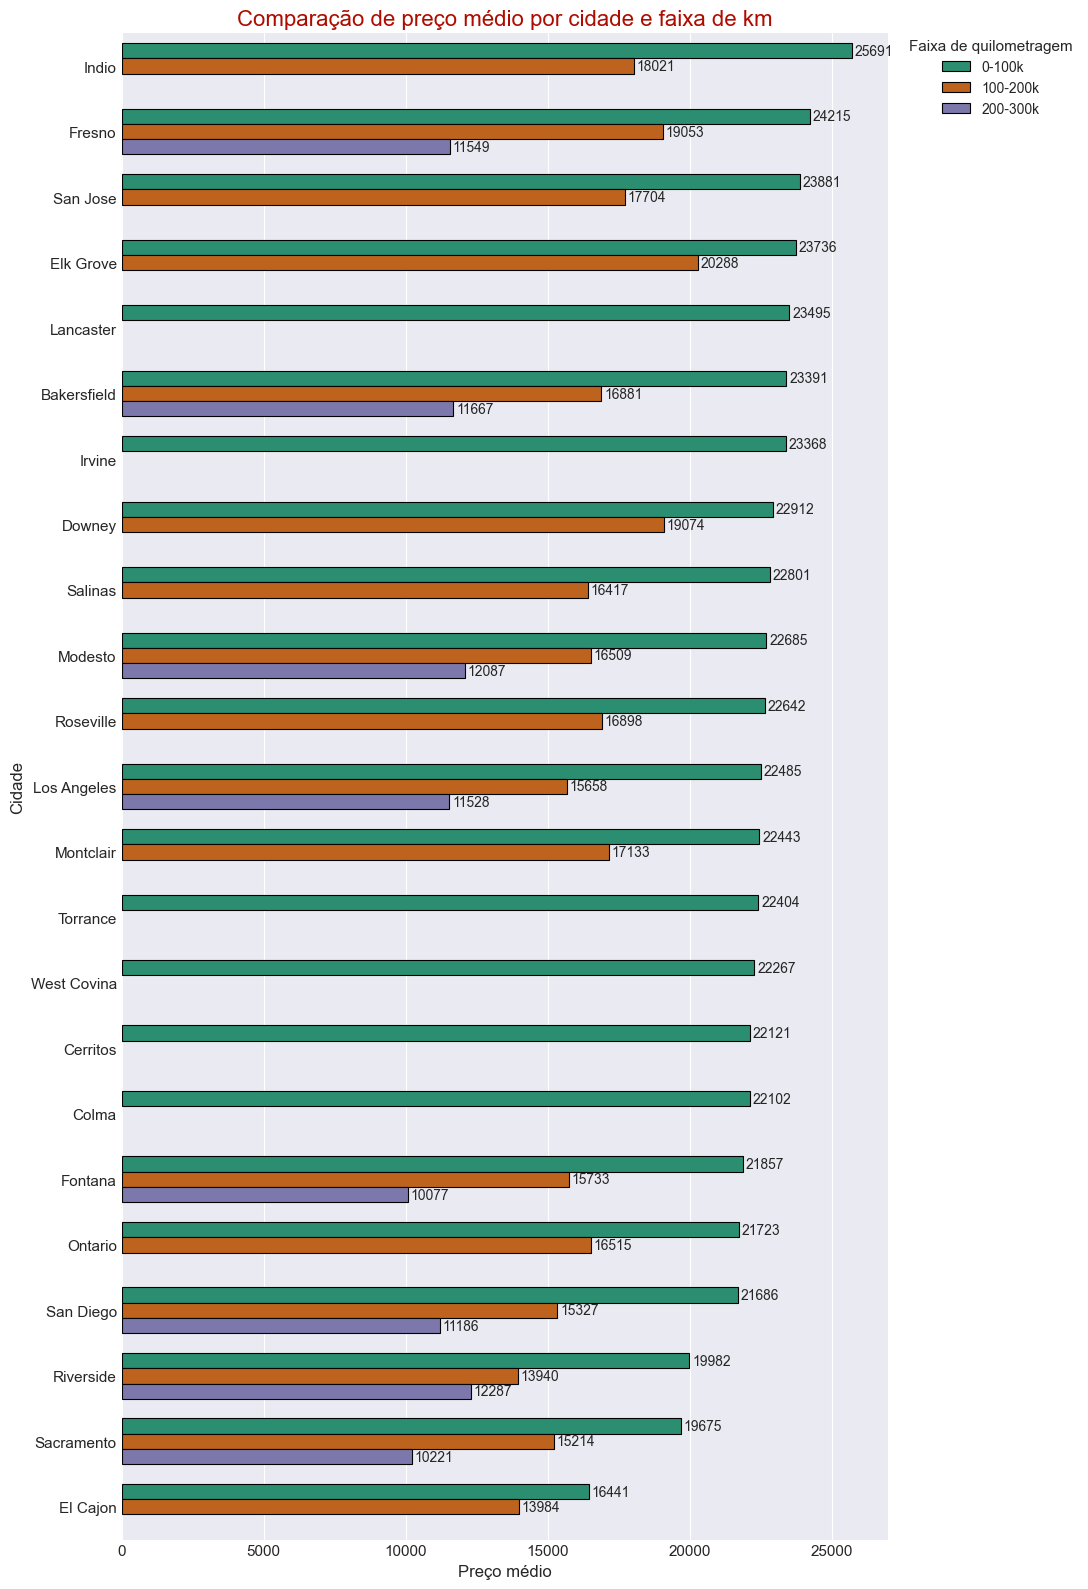

In [33]:
plt.figure(figsize=(11, 16))

ordem_cidades = (
    df_cidade_faixa_preco[df_cidade_faixa_preco['faixa_km'] == '0-100k']
    .sort_values('preco_medio', ascending=False)['cidade_revendedor']
)
palette = ["#1b9e77", "#d95f02", "#7570b3"]
ax = sns.barplot(
    data=df_cidade_faixa_preco,
    x="preco_medio",
    y="cidade_revendedor",
    hue="faixa_km",
    order=ordem_cidades,
    dodge=True,
    width=0.7,
    edgecolor="black",
    linewidth=0.8,
    palette=palette
)
ax.set_title(
    "Comparação de preço médio por cidade e faixa de km",
    fontsize=16, color="#ae0c00"
)
ax.set_xlabel("Preço médio", fontsize=12)
ax.set_ylabel("Cidade", fontsize=12)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=2)

ax.legend(
    title="Faixa de quilometragem",
    title_fontsize=11,
    fontsize=10,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.show()

## 4. Relação entre quilometragem e preço

In [34]:
df_corr_idade = pd.read_csv("../data/sql_exports/correlacao_idade.csv")

### 4.1 Correlação de Pearson por idade do veículo

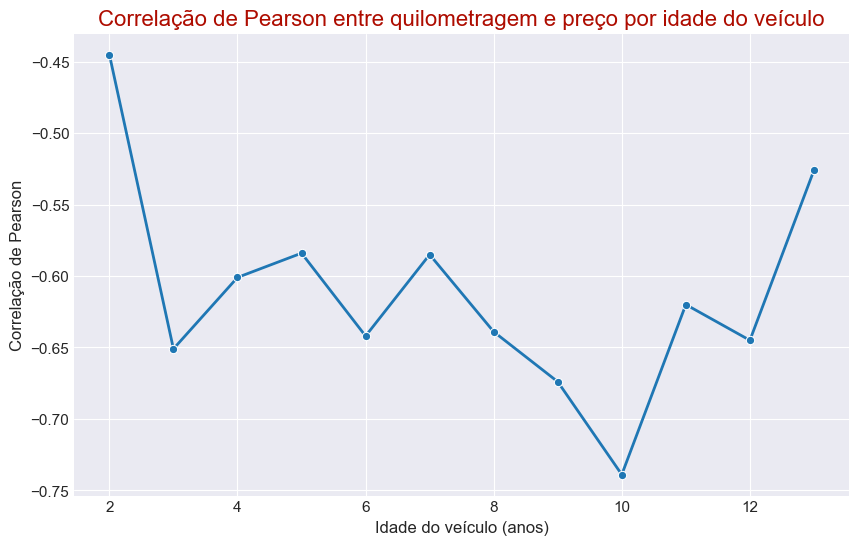

In [35]:
plot_line(df_corr_idade, 'idade', 'corr_pearson', "Correlação de Pearson entre quilometragem e preço por idade do veículo", 
          "Idade do veículo (anos)", "Correlação de Pearson", (10,6))

## Créditos e contato

**Desenvolvido por:**  
Bruno Casini

**GitHub:**  
[<img src="https://img.icons8.com/ios-filled/20/000000/github.png"/> GitHub](https://github.com/kzini)  
`https://github.com/kzini`

**LinkedIn:**  
[<img src="https://img.icons8.com/ios-filled/20/000000/linkedin.png"/> LinkedIn](https://www.linkedin.com/in/kzini)  
`https://www.linkedin.com/in/kzini`